# Modelo SEIRU:
”S” como suscetíveis, ”E” como expostos, ”I” como infectados assintomáticos, ”R” como indiv´ıduos com sintomas e devidamente testados e ”U” como indivíduos com sintomas que não foram testados.

$$
\begin{align}
v&=v_1 + v_2 \\ \\
S'(t)&=-\tau(t)S(T)(I(t)+U(t))\\
S(t_0)&=S_0 >0; \\ \\
E'(t)&=\tau(t)S(t)(I(t)+U(t)) - \alpha E(t),\\
E(t_0)&=E_0 >0; \\ \\
I'(t)&=\alpha E(t)-(v_{1}+v_{2}) I(t)\\
I(t_0)&=I_0 >0; \\ \\
R'(t)&=v_{1}I(t)-\eta R(t)\\
R(t_0)&=R_0=0; \\ \\
U'(t)&=v_2 I(t)- \eta U(t)\\
U(t_0)&=U_0 >0; \\ \\
\\
\end{align}
$$




------------------------------------------------------------------------------------------------------------------------------
## Análise Dimensional:
Todas as derivadas dC/dt (sendo C um compartimento do modelo) acima têm dimensão $[dC/dt] = T^-1$, pois são taxas de variação "indivíduos por tempo". 

Desta forma, fica claro que pela primeira equação, $[\tau ]=[dS/dt]=T^{-1}$. 

Pela eq. de $E'(t)$, temos que $[\alpha *E]=[\tau*S*(I+U)]$, logo $[\alpha]=[\tau]=T^{-1}$.

Pela eq. de $I'(t)$, temos que $[v_1]=[v_2]=[\alpha]=T^{-1}$ e, portanto, $[v]=T^{-1}$. 

Finalmente, por $R'(t)$, $[\eta]=[v_1]=T^{-1}$.



In [2]:
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install parameter-sherpa
#!{sys.executable} -m pip install lmfit
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install salib
#!{sys.executable} -m pip install plotly

In [3]:
%display typeset

import sympy
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from lmfit import minimize, Parameters, Parameter, report_fit
import os
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.widgets import Slider, Button, RadioButtons
from IPython.html.widgets import *


/opt/sagemath-9.1/local/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



In [4]:
var('S E I R U tau alpha v1 v2 eta')

(S, E, I, R, U, tau, alpha, v1, v2, eta)

In [5]:
def seiru (t,y, pars):
    S,E,I,R,U = y
    tau, alpha, eta, v1, v2 = pars
    return [-tau*S*(I + U),         #dS/dt
            tau*S*(I + U) -alpha*E, #dE/dt
            alpha*E-(v1+v2)*I,            #dI/dt
            v1*I-eta*R,             #dR/dt
            (v2)*I-eta*U          #dU/dt
            ]

In [6]:
solve(seiru([0,200],[S,E,I,R,U],[tau, alpha, eta, v1, v2]),[S,E,I,R,U])

[[S == r1, E == 0, I == 0, R == 0, U == 0]]

# Calculando o R0

In [7]:
jack=jacobian(seiru([0,200],[S,E,I,R,U],[tau, alpha, eta, v1, v2]),[S,E,I,R,U])
jack

[-(I + U)*tau            0       -S*tau            0       -S*tau]
[ (I + U)*tau       -alpha        S*tau            0        S*tau]
[           0        alpha     -v1 - v2            0            0]
[           0            0           v1         -eta            0]
[           0            0           v2            0         -eta]

In [8]:
cp = jack.characteristic_polynomial()
cp

x^5 + (I*tau + U*tau + alpha + 2*eta + v1 + v2)*x^4 + (I*alpha*tau - S*alpha*tau + U*alpha*tau + 2*I*eta*tau + 2*U*eta*tau + I*tau*v1 + U*tau*v1 + I*tau*v2 + U*tau*v2 + 2*alpha*eta + eta^2 + alpha*v1 + 2*eta*v1 + alpha*v2 + 2*eta*v2)*x^3 + (2*I*alpha*eta*tau - 2*S*alpha*eta*tau + 2*U*alpha*eta*tau + I*eta^2*tau + U*eta^2*tau + I*alpha*tau*v1 + U*alpha*tau*v1 + 2*I*eta*tau*v1 + 2*U*eta*tau*v1 + I*alpha*tau*v2 - S*alpha*tau*v2 + U*alpha*tau*v2 + 2*I*eta*tau*v2 + 2*U*eta*tau*v2 + alpha*eta^2 + 2*alpha*eta*v1 + eta^2*v1 + 2*alpha*eta*v2 + eta^2*v2)*x^2 + (I*alpha*eta^2*tau - S*alpha*eta^2*tau + U*alpha*eta^2*tau + 2*I*alpha*eta*tau*v1 + 2*U*alpha*eta*tau*v1 + I*eta^2*tau*v1 + U*eta^2*tau*v1 + 2*I*alpha*eta*tau*v2 - S*alpha*eta*tau*v2 + 2*U*alpha*eta*tau*v2 + I*eta^2*tau*v2 + U*eta^2*tau*v2 + alpha*eta^2*v1 + alpha*eta^2*v2)*x + I*alpha*eta^2*tau*v1 + U*alpha*eta^2*tau*v1 + I*alpha*eta^2*tau*v2 + U*alpha*eta^2*tau*v2

$$ {\cal F}_i(x): \text{ taxa de surgimento de novos infectados no compartimento } i $$


In [9]:
F_cal = matrix([[tau*S*(I + U)],[0],[0],[0]])
F_cal

[(I + U)*S*tau]
[            0]
[            0]
[            0]

-------------------------------------------------------------------------------

$$ {\cal V}_i(x)^-: \text{ taxa de saída do compartimento } i $$

$$ {\cal V}_i(x)^+: \text{ taxa de entrada do compartimento } i $$

$$ \therefore  $$



In [10]:
#(E,I,R,U)
V_cal_neg = matrix([[alpha*E],[(v1+v2)*I],[eta*R],[eta*U]])
V_cal_neg

[    E*alpha]
[I*(v1 + v2)]
[      R*eta]
[      U*eta]

In [11]:
V_cal_pos = matrix([[0],[alpha*E],[v1*R],[(v2)*U]])
V_cal_pos

[      0]
[E*alpha]
[   R*v1]
[   U*v2]

In [12]:
V_cal = V_cal_neg-V_cal_pos
V_cal

[               E*alpha]
[-E*alpha + I*(v1 + v2)]
[          R*eta - R*v1]
[          U*eta - U*v2]

Definimos também $F=\left[\frac{\partial {\cal F}_i (x_0)}{\partial x_j}\right]$ e $V=\left[\frac{\partial {\cal V}_i (x_0) }{\partial x_j}\right]$, onde $x_0$ é um DFE (Equilíbrio livre de doença) e $1\leq i,j \leq m$. 

Isto equivale à jacobiana  destas duas matrizes, após substituir $x_0$ ou seja, $S=1$.

In [13]:
F = jacobian(F_cal(S=1),[E,I,R,U])
F

[  0 tau   0 tau]
[  0   0   0   0]
[  0   0   0   0]
[  0   0   0   0]

In [14]:
V = jacobian(V_cal(S=1),[E,I,R,U])
V

[   alpha        0        0        0]
[  -alpha  v1 + v2        0        0]
[       0        0 eta - v1        0]
[       0        0        0 eta - v2]

$${\cal R}_0 = \rho (FV^{-1})$$
\\
The reproductive index is defined as the dominant eigenvalue of the matrix
$$FV^-1$$
; the linearized infection subsystem F and V.

In [15]:
M = F*V.inverse()
M

[ tau/(v1 + v2)  tau/(v1 + v2)              0 tau/(eta - v2)]
[             0              0              0              0]
[             0              0              0              0]
[             0              0              0              0]

In [16]:
M=M.simplify_full()
M

[ tau/(v1 + v2)  tau/(v1 + v2)              0 tau/(eta - v2)]
[             0              0              0              0]
[             0              0              0              0]
[             0              0              0              0]

In [17]:
M.eigenvalues()

[tau/(v1 + v2), 0, 0, 0]

In [18]:
R0=M[0,0].simplify_full()
R0

tau/(v1 + v2)

In [19]:
R0.variables()

(tau, v1, v2)

In [20]:
Ft = jacobian(F_cal,[E,I,R,U])
Vt = jacobian(V_cal,[E,I,R,U])
Mt = Ft*Vt.inverse()
show(pretty_print(html('$R_t=$')))
Rt = Mt[0,0]
Rt

<script type="math/tex">R_t=</script>

None

S*tau/(v1 + v2)

In [21]:
print(Rt)

S*tau/(v1 + v2)


In [22]:
R0(alpha=0.2, v1=0.7*0.2, v2= 0.3*0.2, eta = 0.1, tau = 0.4)

2.00000000000000

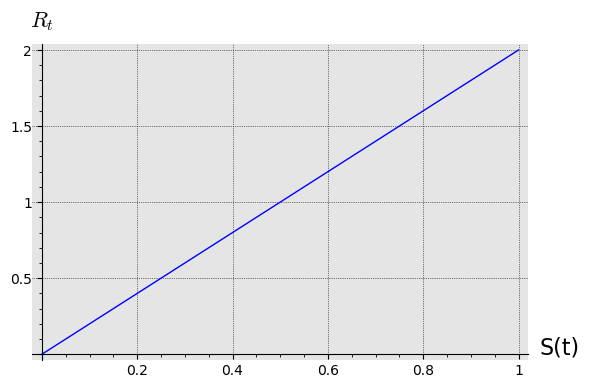

In [23]:
P = plot(Rt(alpha=0.2, v1=0.7*0.2, v2= 0.3*0.2, eta = 0.1, tau = 0.4),(S,0,1))
P.show(axes_labels=['S(t)','$R_t$'], gridlines=True)

## Equilíbrios

In [24]:
alpha, v1, v2, eta, tau = [.2,.14,.06,.1,.4] 
T = ode_solver()
T.function = seiru
T.algorithm='rk8pd'
inits = [.99,0,1e-4,0,0]
tspan = [0,200]
T.ode_solve(tspan, y_0=inits, num_points=1000, params=[tau, alpha, eta, v1, v2])

In [25]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)


array([[9.90000000e-01, 0.00000000e+00, 1.00000000e-04, 0.00000000e+00,
        0.00000000e+00],
       [9.89992186e-01, 7.65942720e-06, 9.62317847e-05, 2.71872486e-06,
        1.16516780e-06],
       [9.89984563e-01, 1.48311510e-05, 9.29018682e-05, 5.28533447e-06,
        2.26514334e-06],
       ...,
       [4.86876220e-02, 8.92762243e-06, 1.47107423e-05, 9.55810322e-05,
        4.09632995e-05],
       [4.86874068e-02, 8.78846506e-06, 1.44812294e-05, 9.40930099e-05,
        4.03255757e-05],
       [4.86871950e-02, 8.65147803e-06, 1.42553023e-05, 9.26281398e-05,
        3.96977742e-05]])

### Sem alteração dos parâmetros, há apenas 1 onda em nosso modelo, e o equilíbrio é da forma:

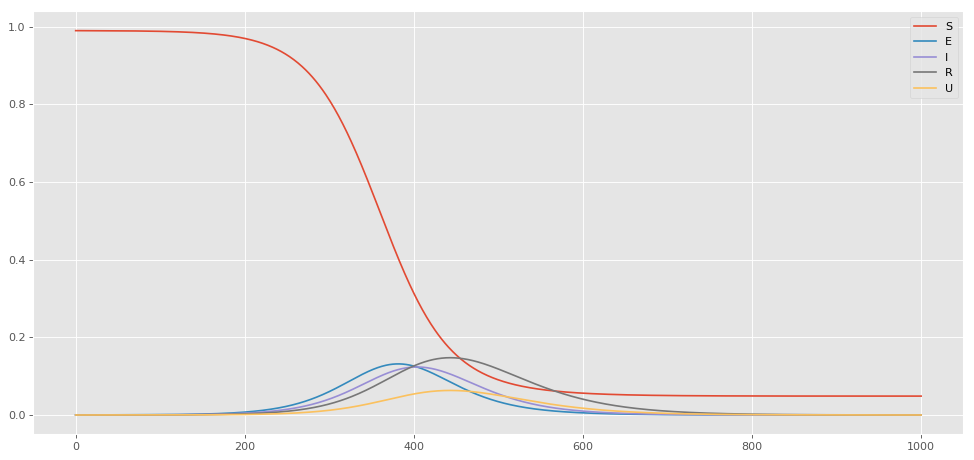

In [26]:
a=get_sim_array(T.solution)
plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(a[:,0],label='S')
plt.plot(a[:,1],label='E')
plt.plot(a[:,2],label='I')
plt.plot(a[:,3],label='R')
plt.plot(a[:,4],label='U')
plt.grid(True)
plt.legend()

## Os dados da Espanha

In [28]:
spain = pd.read_csv('covid.csv')
spain=spain.loc[spain["location"]=="Spain"]
spain.index = range(len(spain))
spain['data'] = pd.to_datetime(spain.date)

In [29]:
spain.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'data'],
      dtype='object')

In [207]:
popES=46760000

new_cases=list(spain['new_cases'])[9:]  #começa no dia do primeiro caso
new_deaths=list(spain["new_deaths"])[9:]

total_cases=[1]
total_deaths=[0]

new_cases = signal.savgol_filter(new_cases,7,1)
new_deaths= signal.savgol_filter(new_deaths,7,1)

d=len(new_cases)

for i in range(1,d):
    total_cases.append(total_cases[i-1]+new_cases[i])   
    total_deaths.append(total_deaths[i-1]+new_deaths[i])

data = np.array(new_cases)/popES

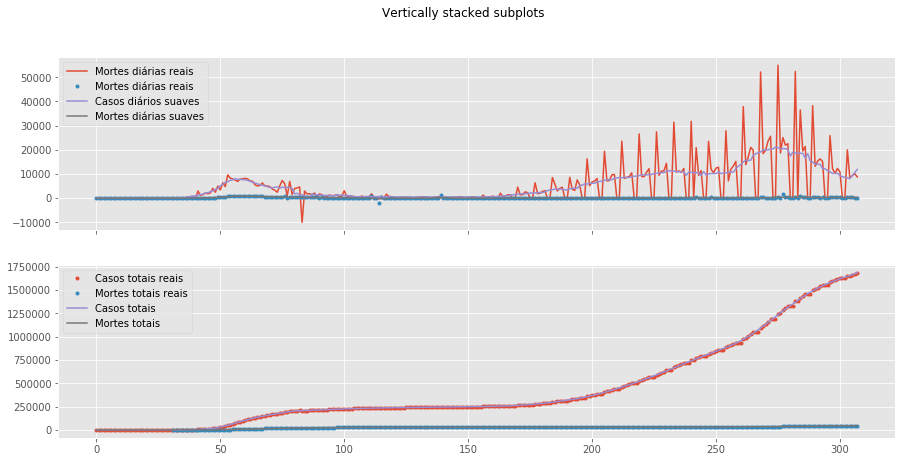

In [208]:
fig, axs = plt.subplots(2,1, sharex=True,figsize=(15, 7))
fig.suptitle('Vertically stacked subplots')

axs[0].plot(range(d),list(spain['new_cases'])[9:],label='Mortes diárias reais')
axs[0].plot(range(d),list(spain['new_deaths'])[9:],'.',label='Mortes diárias reais')
axs[0].plot(range(d),new_cases, label='Casos diários suaves')
axs[0].plot(range(d),new_deaths,label='Mortes diárias suaves')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(range(d),list(spain["total_cases"])[9:],'.',label='Casos totais reais')
axs[1].plot(range(d),list(spain["total_deaths"])[9:],'.',label='Mortes totais reais')
axs[1].plot(range(d),total_cases, label='Casos totais')
axs[1].plot(range(d),total_deaths,label='Mortes totais')
axs[1].grid(True)
axs[1].legend()

In [ ]:
fig, axs = plt.subplots(2,1, sharex=True,figsize=(15, 7))
fig.suptitle('Vertically stacked subplots')

axs[0].plot(range(d),list(spain['new_cases'])[9:],label='Mortes diárias reais')
axs[0].plot(range(d),list(spain['new_deaths'])[9:],'.',label='Mortes diárias reais')
axs[0].plot(range(d),new_cases, label='Casos diários suaves')
axs[0].plot(range(d),new_deaths,label='Mortes diárias suaves')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(range(d),list(spain["total_cases"])[9:],'.',label='Casos totais reais')
axs[1].plot(range(d),list(spain["total_deaths"])[9:],'.',label='Mortes totais reais')
axs[1].plot(range(d),total_cases, label='Casos totais')
axs[1].plot(range(d),total_deaths,label='Mortes totais')
axs[1].grid(True)
axs[1].legend()

## Fitting do modelo SEIRU nos dados considerando 2 ondas

In [178]:
from lmfit import minimize, Parameters, Parameter, report_fit

In [227]:
def seiru (x0, t, ps):
    
    try:       
        tau = ps['tau'].value       #<-primeira onda
        alpha = ps['alpha'].value
        eta = ps['eta'].value
        v1 = ps['v1'].value
#EM SEGUIDA: tentar v = ps['v'].value fixo e v2=v-v1 com v1 variável
        v2 = ps['v2'].value
        
        tau2 = ps['tau2'].value     #<-segunda onda
        v12 = ps['v12'].value
        v22 = ps['v22'].value
        
        tau3 = ps['tau3'].value     #<-segunda onda
        v13 = ps['v13'].value
        v23 = ps['v23'].value
        
        t1tau = ps['t1tau'].value
        t1v1 = ps['t1v1'].value     #<---|
        t1v2 = ps['t1v2'].value     #    \
#                                        |-- tempos de alteração entre primeira onda, tempo "calmo" e segunda onda.
        t2tau = ps['t2tau'].value   #    \
        t2v1 = ps['t2v1'].value     #<---|
        t2v2 = ps['t2v2'].value
        
        
    except:
        tau, alpha, eta, v1, v2, tau2, v12, v22, tau3, v13, v23, t1tau, t1v1, t1v2, t2tau ,t2v1 ,t2v2 = ps
        
    S,E,I,R,U = x0

# Na segunda onda, há  uma diferença na taxa média de contaminação tau
# e também pode ter ocorrido mudanças na efetividade de reportar novos 
# casos, o que altera a proporção entre v1 e v2. 

    if t> t1tau and t<=t2tau:
        tau=tau2
    elif t>t2tau:
        tau=tau3
        
    if t> t1v1 and t<=t2v1:
        v1=v12
    elif t>t2v1:
        v1=v13
        
    if t>tv2 and t<=t2v1:
        v2=v22
    elif t>t2v1:
        v2=v23
    
    return [-tau*S*(I + U),         #dS/dt
            tau*S*(I + U) -alpha*E, #dE/dt
            alpha*E-(v1+v2)*I,      #dI/dt
            v1*I-eta*R,             #dR/dt
            v2*I-eta*U              #dU/dt
            ]
def engine(t, x0, ps):
    St = 1 - np.sum(x0)
    x0 = np.insert(x0,0,St)
    x = odeint(seiru, x0, t, args = (ps,))
    return x

def res(ps, t, data):
    x0 = ps['E'].value, ps['I'].value, ps['R'].value, ps['U'].value
    model = engine(t, x0, ps)
    return (model[:,3] - data).ravel()      


## Observando um equilíbrio


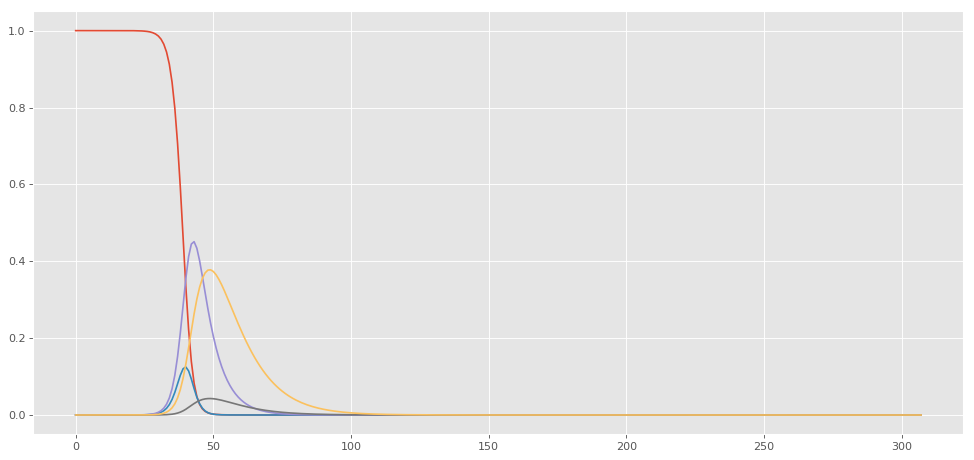

In [180]:
t=range(d)
x0 = np.array([0.002*10^(-6),0.002*10^(-6),0.002*10^(-6),0.002*10^(-6)])
tau, alpha, eta, v1, v2, tau2, v12, v22, tau3, v13, v23, t1tau, t1v1, t1v2, t2tau ,t2v1 ,t2v2= [0.75, 1, 0.1, 0.017, 0.15, 0.1,0.005,0.027, 150, 100,100]
params = np.array([tau, alpha, eta, v1, v2 , tau2, v12, v22, ttau, tv1, tv2])
modelo = engine(t, x0, params)
plt.figure(num=None, figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')
for i in range(5):
    plt.plot(modelo[:,i])  
plt.show()

O imfit tentará atribuir os valores ótimos aos parâmetros (inclusive ao momento em que alguns deles se alteram pra segunda onda)

In [318]:
params = Parameters()

params.add('E', value=.0001, min=0, max=1,vary= False )
params.add('I', value=.0001, min=0, max=1, vary= False)
params.add('R', value=.00001, min=0, max=1, vary= False)
params.add('U', value=.00001, min=0, max=1, vary= False)

params.add('tau', value=0.4, min=0, max=1)
params.add('alpha', value=0.82912460, min=0.8, max=1)
params.add('eta', value=1/7, min=1/7-0.01, max=1/7+0.01)
params.add('v1', value=0.0017832, min=0.0016832, max=0.0018832)
params.add('v2', value=0.212139, min=0.211139, max=.313139)

params.add('tau2', value=0.8908258, min=0.8907258, max=0.8909258)
params.add('v12', value=0.00032704, min=0.00031704, max=0.00033704)
params.add('v22', value=0.1121699, min=0.1120699, max=0.1122699)
params.add('t1tau', value=80, min=80, max=110)
params.add('t1v1', value=80, min=80, max=110)
params.add('t1v2', value=80, min=80, max=100)

params.add('tau3', value=0.50003876,min=0, max=1)
params.add('v13', value=0.0059311, min=0.00033211, max=0.00733411)
params.add('v23', value=0.00998879, min=0.00804098, max=0.00604098)
params.add('t2tau', value=150, min=120, max=165)
params.add('t2v1', value=150, min=120, max=165)
params.add('t2v2', value=150, min=120, max=165)

result = minimize(res, params, args = (t, data), method= 'leastsq')


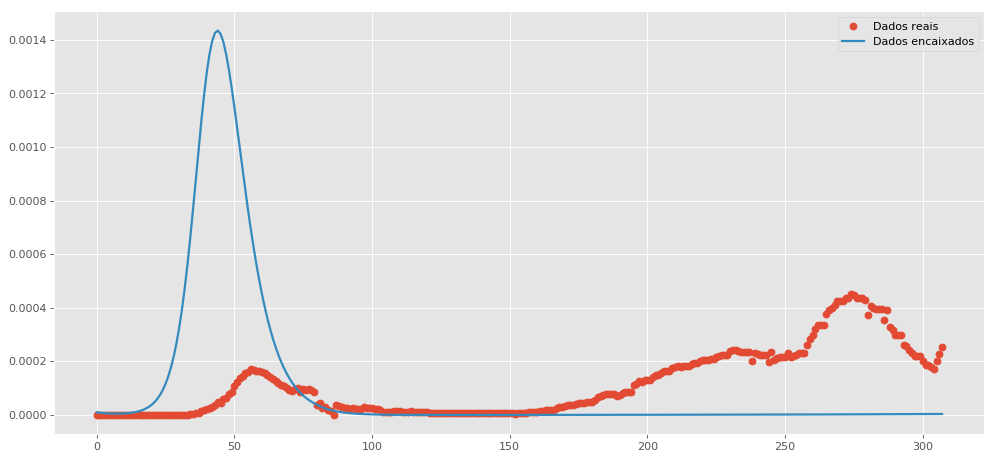

In [319]:
final = data + result.residual.reshape(data.shape)

plt.figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(d), data, 'o',label='Dados reais')
plt.plot(range(d), final, '-', label='Dados encaixados', linewidth=2)
plt.grid(True)
plt.legend()

In [285]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 627
    # data points      = 308
    # variables        = 17
    chi-square         = 5.0519e-06
    reduced chi-square = 1.7360e-08
    Akaike info crit   = -5487.16210
    Bayesian info crit = -5423.75040
##  Warning: uncertainties could not be estimated:
    tau2:   at boundary
    v12:    at initial value
    v22:    at boundary
    t1tau:  at initial value
    t1tau:  at boundary
    t1v1:   at initial value
    t1v1:   at boundary
    t1v2:   at initial value
    t1v2:   at boundary
    v13:    at initial value
    v23:    at boundary
    t2tau:  at initial value
    t2v1:   at initial value
    t2v2:   at initial value
[[Variables]]
    E:      0.0001 (fixed)
    I:      0.0001 (fixed)
    R:      1e-05 (fixed)
    U:      1e-05 (fixed)
    tau:    0.39999499 (init = 0.4)
    alpha:  0.80431143 (init = 0.8291246)
    eta:    0.36352622 (init = 0.241097)
    v1:     0.00168334 (init = 0.0017832)
    v2: 

In [317]:
R0(alpha=0.80431143, v1= 0.00233311, v2= 0.00804098, eta = 0.16, tau = 0.70000845)

67.4766124064858